In [1]:
%matplotlib inline


# Imputing missing values before building an estimator


Missing values can be replaced by the mean, the median or the most frequent
value using the basic :class:`sklearn.impute.SimpleImputer`.
The median is a more robust estimator for data with high magnitude variables
which could dominate results (otherwise known as a 'long tail').

With ``KNNImputer``, missing values can be imputed using the weighted
or unweighted mean of the desired number of nearest neighbors.

Another option is the :class:`sklearn.impute.IterativeImputer`. This uses
round-robin linear regression, treating every variable as an output in
turn. The version implemented assumes Gaussian (output) variables. If your
features are obviously non-Normal, consider transforming them to look more
Normal so as to potentially improve performance.

In addition of using an imputing method, we can also keep an indication of the
missing information using :func:`sklearn.impute.MissingIndicator` which might
carry some information.


In [2]:
pip install --pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn


Looking in links: https://sklearn-nightly.scdn8.secure.raxcdn.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sklearn
sklearn.__version__

'0.21.3'

Automatically created module for IPython interactive environment


/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Use

/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Use

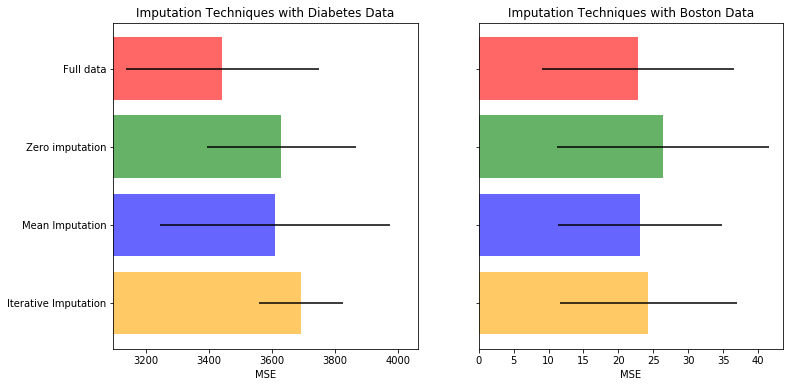

In [4]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import (
    SimpleImputer, IterativeImputer, MissingIndicator)
from sklearn.model_selection import cross_val_score

rng = np.random.RandomState(0)

N_SPLITS = 5
REGRESSOR = RandomForestRegressor(random_state=0)


def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(
        make_union(imputer, MissingIndicator(missing_values=0)),
        REGRESSOR)
    impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                    scoring='neg_mean_squared_error',
                                    cv=N_SPLITS)
    return impute_scores


def get_results(dataset):
    X_full, y_full = dataset.data, dataset.target
    n_samples = X_full.shape[0]
    n_features = X_full.shape[1]

    # Estimate the score on the entire dataset, with no missing values
    full_scores = cross_val_score(REGRESSOR, X_full, y_full,
                                  scoring='neg_mean_squared_error',
                                  cv=N_SPLITS)

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(np.floor(n_samples * missing_rate))
    missing_samples = np.hstack((np.zeros(n_samples - n_missing_samples,
                                          dtype=np.bool),
                                 np.ones(n_missing_samples,
                                         dtype=np.bool)))
    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[np.where(missing_samples)[0], missing_features] = 0
    y_missing = y_full.copy()

    # Estimate the score after replacing missing values by 0
    imputer = SimpleImputer(missing_values=0,
                            strategy='constant',
                            fill_value=0)
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)

    # Estimate the score after imputation (mean strategy) of the missing values
    imputer = SimpleImputer(missing_values=0, strategy="mean")
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)

    # Estimate the score after kNN-imputation of the missing values
    #imputer = KNNImputer(missing_values=0)
    #knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)

    # Estimate the score after iterative imputation of the missing values
    imputer = IterativeImputer(missing_values=0,
                               random_state=0,
                               n_nearest_features=5,
                               sample_posterior=True)
    iterative_impute_scores = get_scores_for_imputer(imputer,
                                                     X_missing,
                                                     y_missing)

    return ((full_scores.mean(), full_scores.std()),
            (zero_impute_scores.mean(), zero_impute_scores.std()),
            (mean_impute_scores.mean(), mean_impute_scores.std()),
            (iterative_impute_scores.mean(), iterative_impute_scores.std()))


results_diabetes = np.array(get_results(load_diabetes()))
mses_diabetes = results_diabetes[:, 0] * -1
stds_diabetes = results_diabetes[:, 1]

results_boston = np.array(get_results(load_boston()))
mses_boston = results_boston[:, 0] * -1
stds_boston = results_boston[:, 1]

n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

x_labels = ['Full data',
            'Zero imputation',
            'Mean Imputation',
            'Iterative Imputation']
colors = ['r', 'g', 'b', 'orange', 'black']

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(j, mses_diabetes[j], xerr=stds_diabetes[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Imputation Techniques with Diabetes Data')
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9,
             right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('MSE')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot boston results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(j, mses_boston[j], xerr=stds_boston[j],
             color=colors[j], alpha=0.6, align='center')

ax2.set_title('Imputation Techniques with Boston Data')
ax2.set_yticks(xval)
ax2.set_xlabel('MSE')
ax2.invert_yaxis()
ax2.set_yticklabels([''] * n_bars)

plt.show()